# 🤖 Bertopic with abstracts of *Biology and Philosophy* 

In [3]:
# Packages to import. 

import pandas as pd 
import numpy as np
import datamapplot
import pandas as pd 
import os

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP


## 📄 Data
This data is from *Biology and Philosophy* journal from 1986 to 2023. I removed all the entries with no abstract. 


In [4]:
base_dir = "C:\\Users\\jacob\\OneDrive - Université Laval\\biophilo\\Data\\"
data = "PHILOSOPHY_OF_BIOLOGY_ALL.csv"
file_path = os.path.join(base_dir, data)

df = pd.read_csv(file_path)
filtered_df = df[df["subtypeDescription"] == "Article"]
filtered_df['abstract'] = filtered_df.description.dropna()


In [15]:
newdf = filtered_df.dropna(subset=['abstract', 'author_names']) 

In [16]:
docs = newdf.abstract.to_list()

columns_to_combine = ['author_names', 'coverDate', 'title']
newdf['combined'] = newdf[columns_to_combine].apply(lambda row: ', '.join(map(str, row)), axis=1)
node_text = newdf.combined.to_list()

## 🦙 Import Llama for labels

In [8]:
from llama_cpp import Llama

# Use llama.cpp to load in a Quantized LLM

llm = Llama(model_path="C:/Users/jacob/OneDrive/Bureau/openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"])

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from C:/Users/jacob/OneDrive/Bureau/openhermes-2.5-mistral-7b.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = teknium_openhermes-2.5-mistral-7b
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_load

In [9]:
from bertopic.representation import KeyBERTInspired, LlamaCPP

prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}

NameError: name 'llm' is not defined

## 🌌 BERTopic model

In [23]:
# Pre-calculate embeddings
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

Batches:   0%|          | 0/101 [00:00<?, ?it/s]

In [24]:
# Define sub-models
from hdbscan import HDBSCAN
from umap import UMAP
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

## Visualisation Without Llama

In [25]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# Define a custom list of stopwords (or use an extended one)
custom_stopwords = ["the", "and", "or", "in", "on", "at", "of", "is", "to", "with", "are", "that", "this", "as", "by", "be", "we", "oa"]

# Create a CountVectorizer with the custom stopwords
vectorizer = CountVectorizer(stop_words=custom_stopwords)

topic_model = BERTopic(
  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  #representation_model=representation_model,
  vectorizer_model=vectorizer,
  
  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)


2025-01-25 12:10:19,905 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-25 12:10:29,958 - BERTopic - Dimensionality - Completed ✓
2025-01-25 12:10:29,959 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-25 12:10:30,025 - BERTopic - Cluster - Completed ✓
2025-01-25 12:10:30,028 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-25 12:10:30,417 - BERTopic - Representation - Completed ✓


In [26]:
topic_model.visualize_heatmap()

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchical_documents(docs, hierarchical_topics, reduced_embeddings=reduced_embeddings)

In [27]:
x = topic_model.get_document_info(docs)

y = x.Name
labels =y.values
labels.shape

topic_info = topic_model.get_topic_info()
excluded_topic = str(topic_info.Name[0]) 
clean_labels= [item.replace(excluded_topic, "Unlabelled") for item in labels] # To exclude -1 topic which is typically noise. 

In [28]:
plot = datamapplot.create_interactive_plot(
    reduced_embeddings,
    clean_labels,
    hover_text = node_text,
    enable_search=True, 
    cluster_boundary_polygons=False,
    cluster_boundary_line_width=8,
    color_label_text=True,
    color_cluster_boundaries=False,
    inline_data=True,
    use_medoids = True,
    #background_color="#303446",
    title = f"Philosophy of Biology",  
    sub_title= f"From <i>Scopus</i>",
    polygon_alpha = 5,
    logo = "https://cirst.uqam.ca/wp-content/themes/cirst-theme/public/images/header/logo_complet.934102.png",

    )


plot



<InteractiveFigure width=100% height=800>

## Visualisation With Llama 

In [27]:
topic_model = BERTopic(
  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model, # this is the key line that changes. 
  vectorizer_model=vectorizer,
  
  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-12-20 22:04:29,981 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-20 22:04:36,108 - BERTopic - Dimensionality - Completed ✓
2024-12-20 22:04:36,109 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-20 22:04:36,148 - BERTopic - Cluster - Completed ✓
2024-12-20 22:04:36,152 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|          | 0/36 [00:00<?, ?it/s]llama_perf_context_print:        load time =  168800.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  2781 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     7 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  170217.23 ms /  2788 tokens
  3%|▎         | 1/36 [02:50<1:39:19, 170.28s/it]


ValueError: Requested tokens (8526) exceed context window of 4096

c:\Users\jacob\anaconda3\envs\test\Lib\site-packages\datamapplot\plot_rendering.py:471: GoogleAPIUnreachable: Cannot reach out Google APIs to download the font you selected. Will fallback on fonts already installed.
  warn(
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font famil

  0%|          | 0/500 [00:00<?, ?it/s]

findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.


Resetting positions to accord with alignment


(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'left': 'From Biology & Philosophy (1986-2022)'}>)

findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not

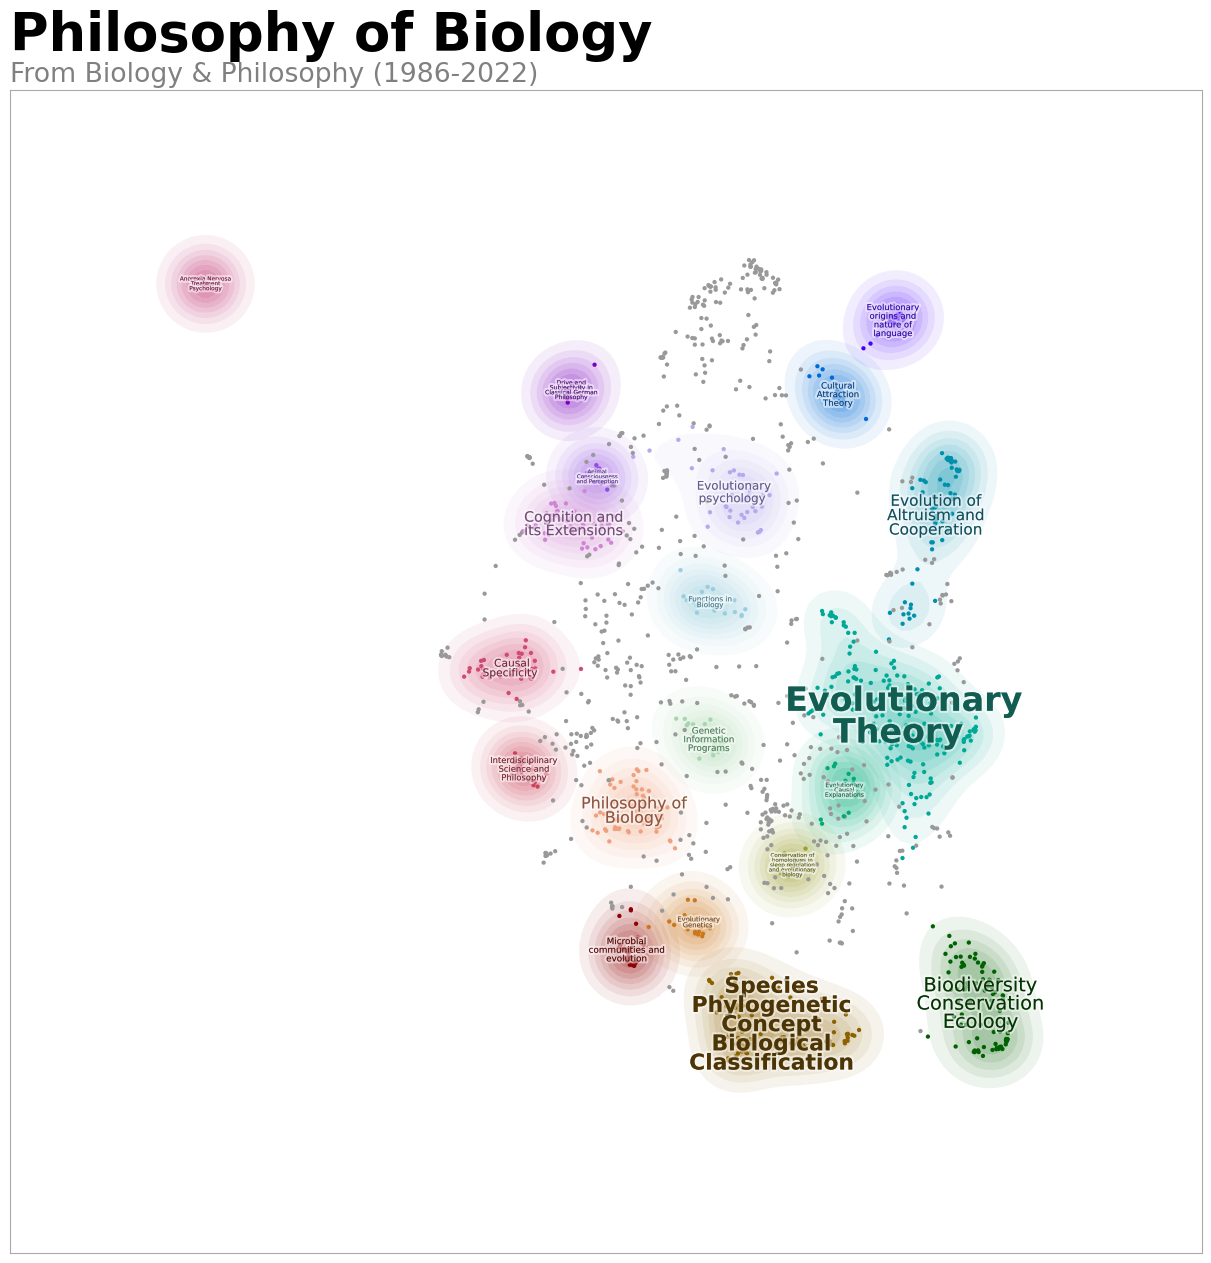

In [12]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_over_points=True, 
    dynamic_label_size=True,
    title = f"Philosophy of Biology",
    sub_title= f"From Biology & Philosophy (1986-2022)")




In [ ]:
plot = datamapplot.create_interactive_plot(
    reduced_embeddings,
    all_labels,
    hover_text = node_text,
    enable_search=True, 
    cluster_boundary_polygons=False,
    cluster_boundary_line_width=8,
    color_label_text=True,
    color_cluster_boundaries=False,
    inline_data=True,
    use_medoids = True,
    #background_color="#303446",
    title = f"Philosophy of Biology",  
    sub_title= f"From <i>Biology & Philosophy</i> (1986-2022)",
    polygon_alpha = 5,
    logo = "https://cirst.uqam.ca/wp-content/themes/cirst-theme/public/images/header/logo_complet.934102.png",

    )


plot


<InteractiveFigure width=100% height=800>

In [ ]:
timestamps = df.year.to_list()
topics_over_time = topic_model.topics_over_time(docs, timestamps)
topics_over_time


topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=3)


39it [00:01, 31.71it/s]
